In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

In [ ]:
# Path to the images
images_directory = '/content/drive/MyDrive/DeepLearning/CuoiKy/flick8k/Images/'
# Path to the captions
captions_path = '/content/drive/MyDrive/DeepLearning/CuoiKy/flick8k/captions.txt'

In [ ]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

In [ ]:
def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Cleaning the captions
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [ ]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

In [ ]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

In [ ]:
# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '114051287_dd85625a04.jpg\tstart a boy dressed in soccer attire and holding his shoes getting out of a car end\n',
 6877.0,
 1092.0,
 122.0)

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Loading the pre-trained InceptionV3 model
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    else:
        print('Unknown image ID !')

pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0]  # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]  # X_caption, Y
                    # ✅ SỬA padding='pre' ➝ padding='post'
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield (np.array(X_images), np.array(X_captions)), np.array(y)




# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048

# Defining batch size
batch_size_train = 270
batch_size_val = 150

# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [ ]:
# Checking shapes
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3248, 2048)
X_captions: (3248, 34)
y: (3248, 8586)
Validation sample batch shapes:
X_images: (1694, 2048)
X_captions: (1694, 34)
y: (1694, 8586)


In [ ]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()


Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Features_Input      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ Features_Input[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sequence_Input      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,198,016 │ Sequence_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8586)      │  2,206,602 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.6))


# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=25, callbacks=[early_stopping, lr_schedule])

Epoch 1/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 84s 615ms/step - loss: 5.1894 - val_loss: 3.7230 - learning_rate: 0.0055
Epoch 2/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 83s 659ms/step - loss: 3.3483 - val_loss: 3.3778 - learning_rate: 0.0030
Epoch 3/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 78s 617ms/step - loss: 2.9466 - val_loss: 3.2683 - learning_rate: 0.0017
Epoch 4/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 81s 645ms/step - loss: 2.7358 - val_loss: 3.2337 - learning_rate: 9.0718e-04
Epoch 5/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 77s 609ms/step - loss: 2.5979 - val_loss: 3.2277 - learning_rate: 4.9787e-04
Epoch 6/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 77s 606ms/step - loss: 2.5171 - val_loss: 3.2202 - learning_rate: 2.7324e-04
Epoch 7/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 76s 603ms/step - loss: 2.4658 - val_loss: 3.2197 - learning_rate: 1.4996e-04
Epoch 8/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 81s 640ms/step - loss: 2.4362 - val_loss: 3.2176 - learning_rate: 8.2297e-05
Epoch 9/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 77s 609ms/step - loss: 2.4178 - val_

In [ ]:
# Lưu mô hình an toàn hơn
caption_model.save('/content/drive/MyDrive/DeepLearning/Models/image_caption_model_2.keras')


In [ ]:
def generate_caption(model, tokenizer, image_feature, max_length):
    in_text = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None or word == 'end':
            break
        in_text += ' ' + word
    return in_text.replace('start ', '').strip()


In [ ]:
def visualize_test_predictions(model, test_image_ids, test_image_features, tokenizer, max_length, num_images=5):
    fig = plt.figure(figsize=(15, 20))
    selected_images = test_image_ids[:num_images]

    for i, image_id in enumerate(selected_images):
        image_path = os.path.join(images_directory, image_id)
        image_feature = np.expand_dims(test_image_features[image_id], axis=0)
        caption = generate_caption(model, tokenizer, image_feature, max_length)

        img = load_img(image_path, target_size=(299, 299))
        ax = fig.add_subplot(num_images, 1, i + 1)
        ax.imshow(img)
        ax.set_title(f"Predicted Caption:\n{caption}", fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def caption_from_drive_image(model, tokenizer, max_length, image_path):
    # Tiền xử lý ảnh giống như khi trích xuất đặc trưng
    img = preprocess_image(image_path)
    features = inception_v3_model.predict(img, verbose=0)

    # Sinh caption
    caption = generate_caption(model, tokenizer, features, max_length)

    # Hiển thị ảnh và caption
    plt.figure(figsize=(6,6))
    image_display = load_img(image_path, target_size=(299, 299))
    plt.imshow(image_display)
    plt.axis('off')
    plt.title(f"Predicted Caption:\n{caption}", fontsize=14)
    plt.show()


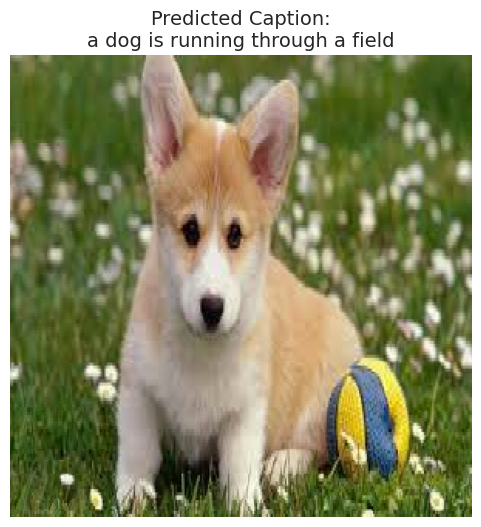

In [ ]:

image_path = '/content/drive/MyDrive/DeepLearning/Image_Caption/concho.jfif'
caption_from_drive_image(caption_model, tokenizer, max_caption_length, image_path)

**load model**

In [ ]:
from tensorflow.keras.models import load_model

caption_model = load_model('/content/drive/MyDrive/DeepLearning/Models/image_caption_model_2.keras')



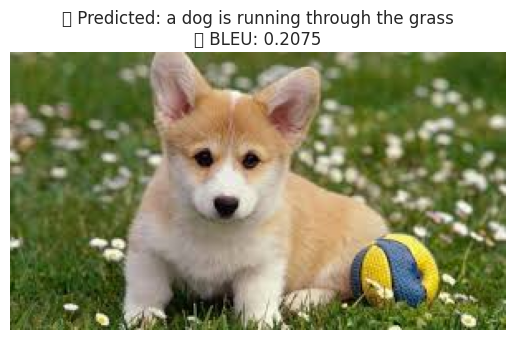

('a dog is running through the grass', 0.20748340713083765)

In [ ]:
image_path = "/content/drive/MyDrive/DeepLearning/Image_Caption/concho.jfif"
ground_truth_caption = "a dog is on the field"
caption_and_bleu_from_drive(image_path, ground_truth_caption)
